# <a name='1'></a>
## 1 - Packages


In [1]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


# <a name='2'></a>
## 2 - Tic-Tac-Toe Environment

In [2]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = [0] * 9  # 0=empty, 1=X, -1=O
        self.winner = None
        self.done = False
        return tuple(self.board)

    def available_actions(self):
        return [i for i, v in enumerate(self.board) if v == 0]

    def step(self, action, player):
        if self.done or self.board[action] != 0:
            raise ValueError("Invalid move")
        self.board[action] = player
        self.winner = self.check_winner()
        if self.winner is not None:
            self.done = True
            reward = 1 if self.winner == player else -1
        elif all(v != 0 for v in self.board):
            self.done = True
            self.winner = 0
            reward = 0.5
        else:
            reward = 0
        return tuple(self.board), reward, self.done

    def check_winner(self):
        wins = [
            [0,1,2],[3,4,5],[6,7,8],  # rows
            [0,3,6],[1,4,7],[2,5,8],  # cols
            [0,4,8],[2,4,6]           # diagonals
        ]
        for line in wins:
            s = sum(self.board[i] for i in line)
            if s == 3: return 1
            if s == -3: return -1
        return None

    def render(self):
        symbols = {1:"X", -1:"O", 0:" "}
        for i in range(0, 9, 3):
            print("|".join(symbols[self.board[i+j]] for j in range(3)))
            if i < 6: print("-----")

# <a name='3'></a>
## 3 - SARSA Agent

In [3]:
class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(float)

    def get_Q(self, state, action):
        return self.Q[(state, action)]

    def choose_action(self, state, actions, training=True):
        if training and random.random() < self.epsilon:
            return random.choice(actions)
        qs = [self.get_Q(state, a) for a in actions]
        max_q = max(qs)
        best = [a for a, q in zip(actions, qs) if q == max_q]
        return random.choice(best)

    def update(self, state, action, reward, next_state, next_action, done):
        q = self.Q[(state, action)]
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.get_Q(next_state, next_action)
        self.Q[(state, action)] = q + self.alpha * (target - q)

# <a name='4'></a>
## 4 - Training Loop

In [4]:
def run_episode_sarsa(env, agent, training=True):
    state = env.reset()
    actions = env.available_actions()
    action = agent.choose_action(state, actions, training)
    total_reward = 0

    while True:
        next_state, reward, done = env.step(action, player=1)
        total_reward += reward

        if done:
            if training:
                agent.update(state, action, reward, next_state, None, True)
            return total_reward, env.winner

        # opponent move
        opp_actions = env.available_actions()
        opp_action = random.choice(opp_actions)
        state, opp_reward, done = env.step(opp_action, player=-1)
        total_reward += opp_reward

        if done:
            if training:
                agent.update(state, action, opp_reward, state, None, True)
            return total_reward, env.winner

        next_actions = env.available_actions()
        next_action = agent.choose_action(state, next_actions, training)

        if training:
            agent.update(state, action, reward, next_state, next_action, False)

        state, action = next_state, next_action

# <a name='5'></a>
## 5 - Plotting Results  

We now train the **SARSA agent** for multiple episodes and visualize:  

- **Total reward per episode**  
- **Win rate across episodes**  

This helps us see how the agent improves over time. 

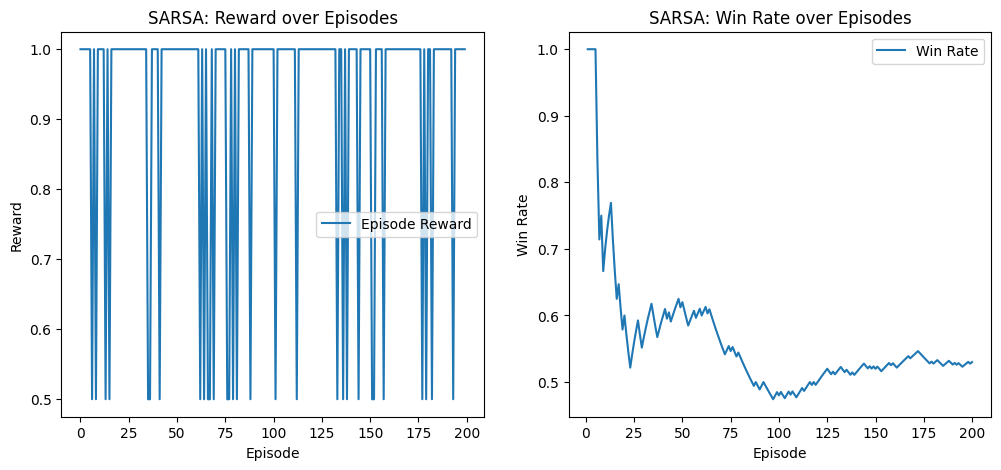

In [5]:
# Train SARSA agent
env = TicTacToe()
sarsa_agent = SARSAAgent(alpha=0.1, gamma=0.9, epsilon=0.2)

episodes = 200
rewards = []
wins = []

for ep in range(episodes):
    total_reward, winner = run_episode_sarsa(env, sarsa_agent, training=True)
    rewards.append(total_reward)
    wins.append(1 if winner == 1 else 0)  # count wins for agent (X)

# Plot rewards and win rate
plt.figure(figsize=(12,5))

# Rewards
plt.subplot(1,2,1)
plt.plot(rewards, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("SARSA: Reward over Episodes")
plt.legend()

# Win rate (moving average)
plt.subplot(1,2,2)
episodes_range = list(range(1, episodes+1))
win_rate_curve = [sum(wins[:i]) / i for i in episodes_range]
plt.plot(episodes_range, win_rate_curve, label="Win Rate")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.title("SARSA: Win Rate over Episodes")
plt.legend()

plt.show()


# <a name='6'></a>
## 6 - Evaluation  

Now we evaluate the trained SARSA agent against a random opponent **without exploration**  
($\epsilon = 0$).  

This shows whether the agent has actually **learned a strong policy**.

In [6]:
# Disable exploration for evaluation
sarsa_agent.epsilon = 0.0

eval_episodes = 50
wins_eval = 0

for ep in range(eval_episodes):
    _, winner = run_episode_sarsa(env, sarsa_agent, training=False)
    if winner == 1:
        wins_eval += 1

print(f"Out of {eval_episodes} evaluation games, SARSA agent won {wins_eval}")


Out of 50 evaluation games, SARSA agent won 32
